/Users/patrick_bloniasz/miniforge3/envs/filtered-point-process/lib/python3.10/site-packages/numpy/lib/function_base.py:1599: ComplexWarning: Casting complex values to real discards the imaginary part
  return interp_func(x, xp, fp, left, right)
/Users/patrick_bloniasz/filtered-point-process/filtered_point_process/point_processes/filtered_point_process.py:613: UserWarning: Effective support of time-domain filter kernels was automatically updated based on a decay threshold of ε = 1.0e-03. This overrides the default or user-specified `filter_time_vector` values for AMPA, GABA, and 1/f filters. If precise temporal support is critical (e.g., for short-duration kernels or fixed-lag analyses), manually specify `filter_time_vector` or adjust `support_eps` in `filter_params`.
  warnings.warn(


[timing] recompute filters took 0.01s
[timing] continuous convolution took 1.45s
[timing] apply_filter_sequences total: 2.31s


/var/folders/y_/cv0__l8d15s4svd34bshwfm40000gn/T/ipykernel_11015/1226707169.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


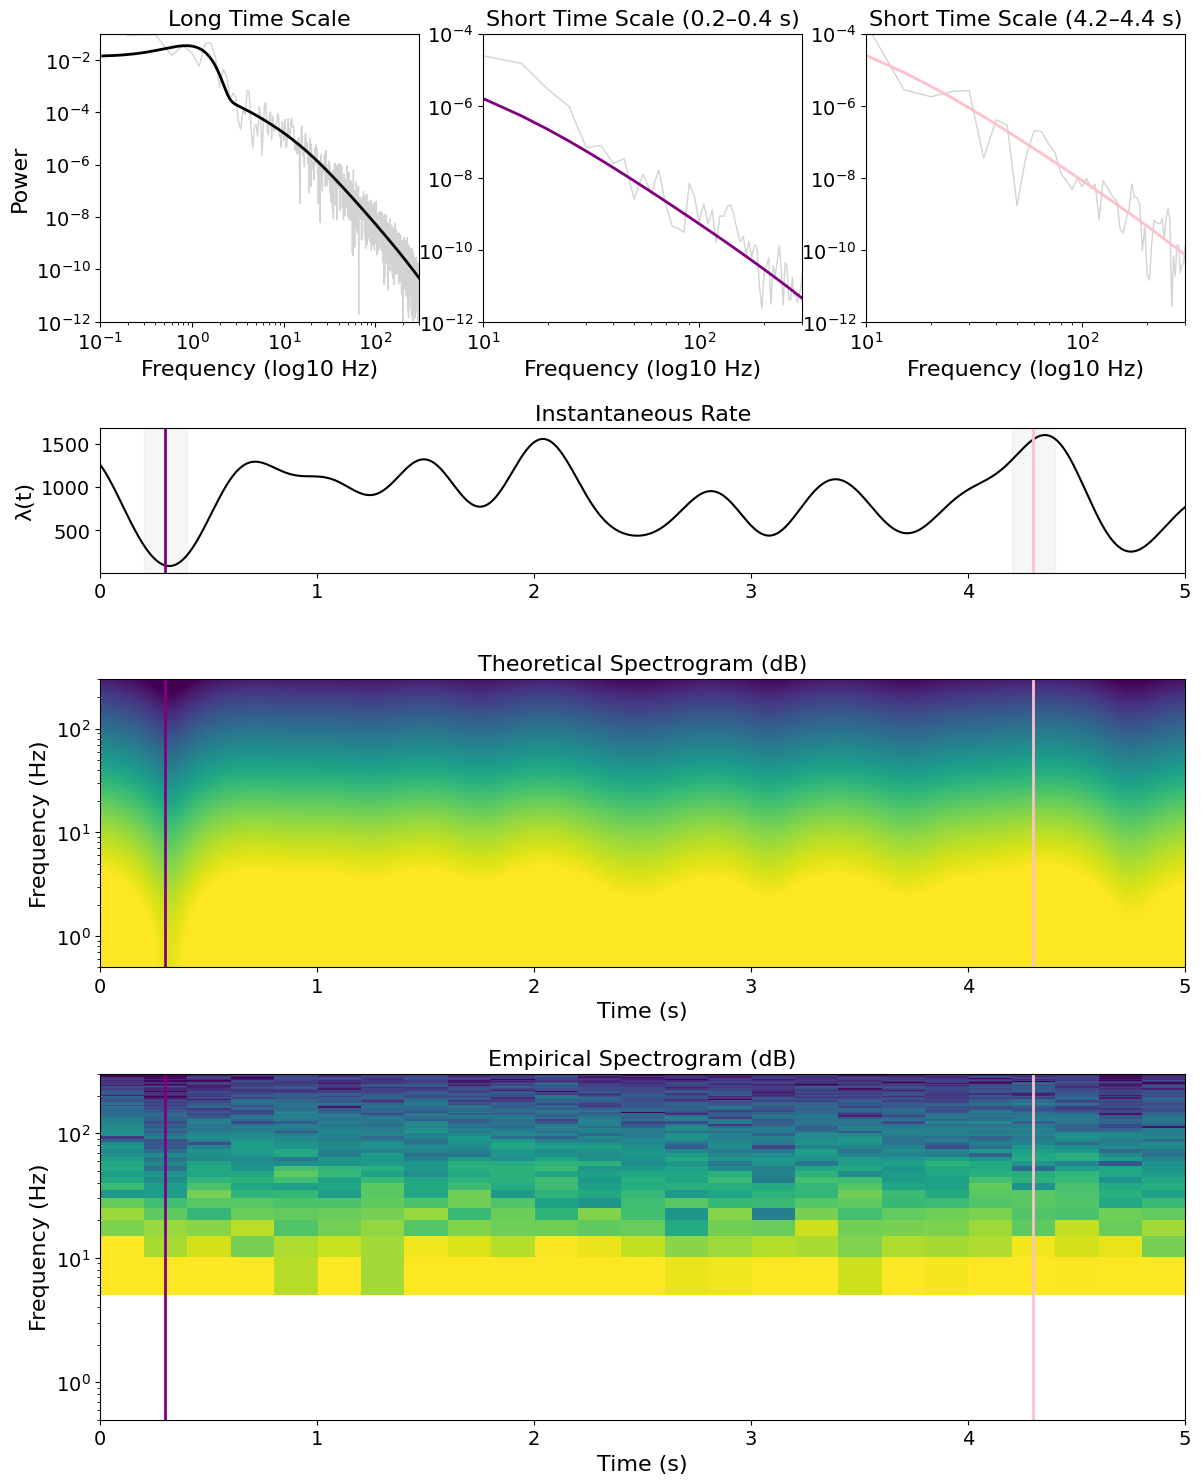

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess

plt.rcParams.update({
    'font.size':          16,
    'axes.titlesize':     16,
    'axes.labelsize':     16,
    'xtick.labelsize':    14,
    'ytick.labelsize':    14,
    'legend.fontsize':    16,
    'figure.titlesize':   16,
})

FS           = 1000.0    # sampling rate (Hz)
DURATION     = 5.0       # total simulation time (s)
SEED         = 17
WIN_DUR      = 0.2       # 0.5 s windows
WIN_STEP     = 0.2       # 0.5 s hop
SHORT_TIMES  = [0.3, 4.3]  # window‐centers for B & C

# Full‐PSD range
FMIN, FMAX   = 0.1, 300.0

# ─── SIMULATE & FILTER ─────────────────────────────────────────────
model_params = {
    "peak_height":      [50000],
    "center_frequency": [1.0],
    "peak_width":       [0.5],
    "lambda_0":         [1000.0],
}
sim_params = {
    "fs":       FS,
    "T":        DURATION,
    "simulate": True,
    "Nsims":    1,
    "seed":     SEED
}

model = Model("gaussian", model_params, sim_params)
fpp   = FilteredPointProcess(model=model, filters={"f1":"GABA","f2":"1/f"})
fpp.apply_filter_sequences([["f1","f2"]])
ts    = fpp.final_time_series_per_process[0]


# ─── FULL-TRACE HANN-TAPER PSD ─────────────────────────────────────
freqs_emp, psd_emp = sps.periodogram(
    ts, fs=FS, window='hann', scaling='density'
)
mask_emp      = (freqs_emp >= FMIN) & (freqs_emp <= FMAX)
fr_emp        = freqs_emp[mask_emp]
psd_emp_full  = psd_emp[mask_emp]

# ─── FULL-TRACE THEORETICAL SPECTRUM ──────────────────────────────
spec        = fpp.get_final_spectrum()
freqs_th    = fpp.model.frequencies
psd_th      = spec["final_total_spectrum"]
mask_th     = (freqs_th >= FMIN) & (freqs_th <= FMAX)
fr_th       = freqs_th[mask_th]
psd_th_full = psd_th[mask_th]

# ─── WINDOWED HANN-TAPER SPECTROGRAM ──────────────────────────────
f_win, t_win, Sxx = sps.spectrogram(
    ts,
    fs=FS,
    window='hann',
    nperseg=int(WIN_DUR*FS),
    noverlap=int((WIN_DUR-WIN_STEP)*FS),
    scaling='density',
    mode='psd'
)
mask_win      = (f_win >= FMIN) & (f_win <= FMAX)
fr_win        = f_win[mask_win]
psd_win_lin_m = Sxx[mask_win, :].T    # shape: (n_win × n_freq)
time_edges    = np.arange(psd_win_lin_m.shape[0] + 1) * WIN_STEP

# ─── INSTANTANEOUS RATE ───────────────────────────────────────────
time_axis = fpp.model.time_axis
lam       = np.real(fpp.model.cif.cif_realization)

# window centers & indices for B/C
n_win       = psd_win_lin_m.shape[0]
win_centers = np.arange(n_win)*WIN_STEP + WIN_DUR/2
win_idx     = [np.argmin(np.abs(win_centers - t)) for t in SHORT_TIMES]
lam_idx     = [np.argmin(np.abs(time_axis   - t)) for t in SHORT_TIMES]

# ─── FILTER-ONLY SPECTRUM for THEORY SHORT WINDOWS ────────────────
H1            = fpp.filter_instances['f1'].kernel_spectrum
H2            = fpp.filter_instances['f2'].kernel_spectrum
Htot_emp_full = H1 * H2
# on full PSD grid:
Htot_emp = np.interp(fr_emp, freqs_th, Htot_emp_full)
# on windowed grid:
Htot_win = np.interp(fr_win, freqs_th, Htot_emp_full)

# ─── THEORETICAL SPECTROGRAM (dB) ─────────────────────────────────
spec_th    = np.outer(lam, Htot_emp)
spec_th_dB = 10 * np.log10(spec_th)
vmin2, vmax2 = np.percentile(spec_th_dB, [1,99])

# ─── EMPIRICAL SPECTROGRAM (dB) ──────────────────────────────────
psd_win_dB = 10 * np.log10(psd_win_lin_m)
vmin3, vmax3 = np.percentile(psd_win_dB, [1,99])

# ─── COLORS for B & C ─────────────────────────────────────────────
colors = ['purple','pink']  # B → purple, C → pink

# ─── MULTI-PANEL PLOT ─────────────────────────────────────────────
fig = plt.figure(figsize=(14,18))
gs  = fig.add_gridspec(4, 3,
                       height_ratios=[1, 0.5, 1, 1.2],
                       hspace=0.4)

ymin, ymax = 1e-12, 1e-1

# ─ Row 1A: Full PSD vs Theory ─────────────────────────────────────
ax1 = fig.add_subplot(gs[0,0])
ax1.loglog(fr_emp, psd_emp_full,  color='lightgrey', lw=1)
ax1.loglog(fr_th,  psd_th_full,   color='black',   lw=2)
ax1.set(xscale='log', yscale='log',
        xlim=(FMIN, FMAX), ylim=(ymin, ymax),
        title='Long Time Scale')
ax1.set_ylabel('Power')
ax1.set_xlabel('Frequency (log10 Hz)')

# ─ Row 1B & 1C: Snapshots at SHORT_TIMES ─────────────────────────
for i, (t, widx, li) in enumerate(zip(SHORT_TIMES, win_idx, lam_idx), start=1):
    ax = fig.add_subplot(gs[0, i])
    emp_short  = psd_win_lin_m[widx]
    lam_mid    = lam[li]
    theo_short = lam_mid * Htot_win
    c          = colors[i-1]

    # empirical in grey, theory in B/C color
    ax.loglog(fr_win, emp_short,  color='lightgrey', lw=1)
    ax.loglog(fr_win, theo_short, color=c,         lw=2)
    ax.set(xscale='log', yscale='log',
           xlim=(10, 300), ylim=(ymin, 1e-4),
           title=f"Short Time Scale ({t-WIN_DUR/2:.1f}–{t+WIN_DUR/2:.1f} s)")
    ax.set_xlabel('Frequency (log10 Hz)')

# ─ Row 2: λ(t) over first 5 s ───────────────────────────────────
axλ = fig.add_subplot(gs[1, :])
axλ.plot(time_axis, lam, lw=1.5, color='black')
axλ.set(xlim=(0,5), ylabel='λ(t)', title='Instantaneous Rate')
# vertical lines at B & C
for t,c in zip(SHORT_TIMES, colors):
    axλ.axvline(t, color=c, lw=2)
# optional: keep lightly shaded intervals
axλ.axvspan(0.2, 0.2 + WIN_DUR,  color='lightgrey', alpha=0.2)
axλ.axvspan(4.2, 4.2+WIN_DUR, color='lightgrey', alpha=0.2)

# ─ Row 3: Theoretical Spectrogram ─────────────────────────────────
ax2 = fig.add_subplot(gs[2, :])
ax2.set_yscale('log')
pcm2 = ax2.pcolorfast(time_edges, fr_emp, spec_th_dB.T,
                      cmap='viridis', vmin=vmin2, vmax=vmax2)
# colored vertical lines
for t,c in zip(SHORT_TIMES, colors):
    ax2.axvline(t, color=c, lw=2)
ax2.set(xlabel='Time (s)', ylabel='Frequency (Hz)',
        title='Theoretical Spectrogram (dB)',
        xlim=(0,5), ylim=(0.5,300))

# ─ Row 4: Empirical Spectrogram ──────────────────────────────────
ax3 = fig.add_subplot(gs[3, :])
ax3.set_yscale('log')
pcm3 = ax3.pcolorfast(time_edges, fr_win, psd_win_dB.T,
                      cmap='viridis', vmin=vmin3, vmax=vmax3)
for t,c in zip(SHORT_TIMES, colors):
    ax3.axvline(t, color=c, lw=2)
ax3.set(xlabel='Time (s)', ylabel='Frequency (Hz)',
        title='Empirical Spectrogram (dB)',
        xlim=(0,5), ylim=(0.5,300))

plt.tight_layout()

import os
outdir = "/Users/patrick_bloniasz/filtered-point-process/examples/Result_3"
os.makedirs(outdir, exist_ok=True)

# save as SVG and PNG
svg_path = os.path.join(outdir, "Result_3.svg")
png_path = os.path.join(outdir, "Result_3.png")
fig.savefig(svg_path, format="svg")
fig.savefig(png_path, format="png", dpi=300)

plt.show()


[timing] recompute filters took 0.01s
[timing] continuous convolution took 1.52s
[timing] apply_filter_sequences total: 2.04s


/var/folders/y_/cv0__l8d15s4svd34bshwfm40000gn/T/ipykernel_11015/2980716853.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


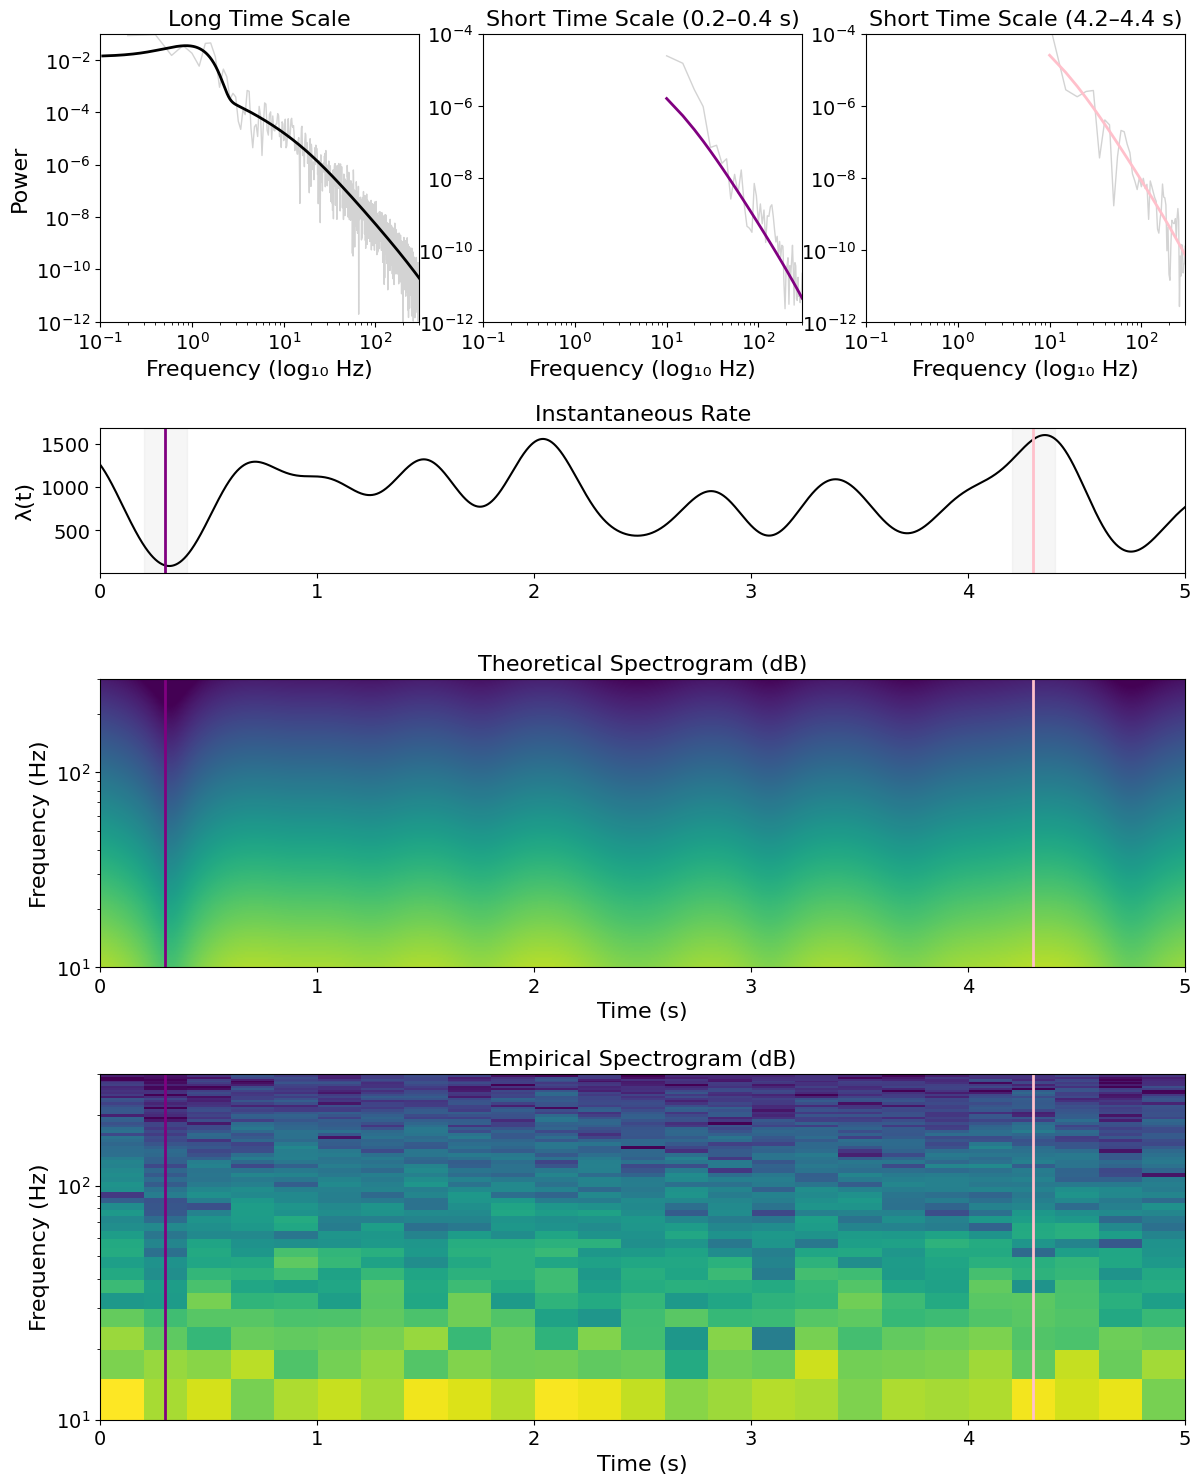

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess
import os

# ─── PLOT STYLING ───────────────────────────────────────────────────
plt.rcParams.update({
    'font.size':          16,
    'axes.titlesize':     16,
    'axes.labelsize':     16,
    'xtick.labelsize':    14,
    'ytick.labelsize':    14,
    'legend.fontsize':    16,
    'figure.titlesize':   16,
})

# ─── PARAMETERS ────────────────────────────────────────────────────
FS           = 1000.0    # sampling rate (Hz)
DURATION     = 5.0       # total simulation time (s)
SEED         = 17
WIN_DUR      = 0.2       # 0.2 s windows
WIN_STEP     = 0.2       # 0.2 s hop
SHORT_TIMES  = [0.3, 4.3]  # window‐centers for B & C
FMIN, FMAX   = 0.1, 300.0  # full PSD range
ymin, ymax   = 1e-12, 1e-1
colors       = ['purple','pink']  # B → purple, C → pink

# ─── SIMULATION & FILTERING ────────────────────────────────────────
model_params = {
    "peak_height":      [50000],
    "center_frequency": [1.0],
    "peak_width":       [0.5],
    "lambda_0":         [1000.0],
}
sim_params = {
    "fs":       FS,
    "T":        DURATION,
    "simulate": True,
    "Nsims":    1,
    "seed":     SEED
}

model = Model("gaussian", model_params, sim_params)
fpp   = FilteredPointProcess(model=model, filters={"f1":"GABA","f2":"1/f"})
fpp.apply_filter_sequences([["f1","f2"]])
ts    = fpp.final_time_series_per_process[0]

# ─── FULL-TRACE HANN-TAPER PSD ────────────────────────────────────
freqs_emp, psd_emp = sps.periodogram(ts, fs=FS, window='hann', scaling='density')
mask_emp       = (freqs_emp >= FMIN) & (freqs_emp <= FMAX)
fr_emp         = freqs_emp[mask_emp]
psd_emp_full   = psd_emp[mask_emp]

# ─── FULL-TRACE THEORETICAL SPECTRUM ──────────────────────────────
spec           = fpp.get_final_spectrum()
freqs_th       = fpp.model.frequencies
psd_th         = spec["final_total_spectrum"]
mask_th        = (freqs_th >= FMIN) & (freqs_th <= FMAX)
fr_th          = freqs_th[mask_th]
psd_th_full    = psd_th[mask_th]

# ─── WINDOWED HANN-TAPER SPECTROGRAM ──────────────────────────────
f_win, t_win, Sxx = sps.spectrogram(
    ts,
    fs=FS,
    window='hann',
    nperseg=int(WIN_DUR*FS),
    noverlap=int((WIN_DUR-WIN_STEP)*FS),
    scaling='density',
    mode='psd'
)
mask_win_full = (f_win >= FMIN) & (f_win <= FMAX)
fr_win        = f_win[mask_win_full]
psd_win_lin_m = Sxx[mask_win_full, :].T    # (n_windows × n_freq)
time_edges    = np.arange(psd_win_lin_m.shape[0] + 1) * WIN_STEP

# ─── INSTANTANEOUS RATE ───────────────────────────────────────────
time_axis  = fpp.model.time_axis
lam        = np.real(fpp.model.cif.cif_realization)
n_win      = psd_win_lin_m.shape[0]
win_centers = np.arange(n_win)*WIN_STEP + WIN_DUR/2
win_idx     = [np.argmin(np.abs(win_centers - t)) for t in SHORT_TIMES]
lam_idx     = [np.argmin(np.abs(time_axis   - t)) for t in SHORT_TIMES]

# ─── FILTER-ONLY SPECTRUM ─────────────────────────────────────────
H1            = fpp.filter_instances['f1'].kernel_spectrum
H2            = fpp.filter_instances['f2'].kernel_spectrum
Htot_emp_full = H1 * H2
# on full PSD grid:
Htot_emp = np.interp(fr_emp, freqs_th, Htot_emp_full)
# on windowed grid:
Htot_win = np.interp(fr_win, freqs_th, Htot_emp_full)

# ─── THEORETICAL SPECTROGRAM (dB) ─────────────────────────────────
spec_th      = np.outer(lam, Htot_emp)
spec_th_dB   = 10 * np.log10(spec_th)
vmin2, vmax2 = np.percentile(spec_th_dB, [1,99])

# ─── EMPIRICAL SPECTROGRAM (dB) ──────────────────────────────────
psd_win_dB   = 10 * np.log10(psd_win_lin_m)
vmin3, vmax3 = np.percentile(psd_win_dB, [1,99])

# ─── MULTI-PANEL PLOT ─────────────────────────────────────────────
fig = plt.figure(figsize=(14,18))
gs  = fig.add_gridspec(4, 3,
                       height_ratios=[1, 0.5, 1, 1.2],
                       hspace=0.4)

# ─ Row 1A: Full PSD vs Theory ─────────────────────────────────────
ax1 = fig.add_subplot(gs[0,0])
ax1.loglog(fr_emp,   psd_emp_full, color='lightgrey', lw=1)
ax1.loglog(fr_th,    psd_th_full,  color='black',     lw=2)
ax1.set(xscale='log', yscale='log',
        xlim=(FMIN, FMAX), ylim=(ymin, ymax),
        title='Long Time Scale')
ax1.set_ylabel('Power')
ax1.set_xlabel('Frequency (log₁₀ Hz)')

# ─ Row 1B & 1C: Snapshots at SHORT_TIMES ─────────────────────────
for i, (t, widx, li) in enumerate(zip(SHORT_TIMES, win_idx, lam_idx), start=1):
    ax = fig.add_subplot(gs[0, i], sharex=ax1)
    mask_short    = fr_win >= 10
    freqs_short   = fr_win[mask_short]
    emp_short     = psd_win_lin_m[widx][mask_short]
    theo_full_win = lam[li] * Htot_win
    theo_short    = theo_full_win[mask_short]

    ax.loglog(freqs_short, emp_short,  color='lightgrey', lw=1)
    ax.loglog(freqs_short, theo_short, color=colors[i-1],     lw=2)
    ax.set(xscale='log', yscale='log',
           xlim=(FMIN, FMAX), ylim=(ymin, 1e-4),
           title=f"Short Time Scale ({t-WIN_DUR/2:.1f}–{t+WIN_DUR/2:.1f} s)")
    ax.set_xlabel('Frequency (log₁₀ Hz)')

# ─ Row 2: λ(t) over first 5 s ───────────────────────────────────
axλ = fig.add_subplot(gs[1, :])
axλ.plot(time_axis, lam, lw=1.5, color='black')
axλ.set(xlim=(0, DURATION), ylabel='λ(t)', title='Instantaneous Rate')
for t,c in zip(SHORT_TIMES, colors):
    axλ.axvline(t, color=c, lw=2)
axλ.axvspan(SHORT_TIMES[0]-WIN_DUR/2, SHORT_TIMES[0]+WIN_DUR/2,
            color='lightgrey', alpha=0.2)
axλ.axvspan(SHORT_TIMES[1]-WIN_DUR/2, SHORT_TIMES[1]+WIN_DUR/2,
            color='lightgrey', alpha=0.2)

# ─ Row 3: Theoretical Spectrogram ─────────────────────────────────
mask_spec        = fr_emp >= 10
fr_spec          = fr_emp[mask_spec]
spec_th_dB_mask  = spec_th_dB[:, mask_spec]

ax2 = fig.add_subplot(gs[2, :])
ax2.set_yscale('log')
pcm2 = ax2.pcolorfast(time_edges, fr_spec, spec_th_dB_mask.T,
                      cmap='viridis', vmin=vmin2, vmax=vmax2)
for t,c in zip(SHORT_TIMES, colors):
    ax2.axvline(t, color=c, lw=2)
ax2.set(xlabel='Time (s)', ylabel='Frequency (Hz)',
        title='Theoretical Spectrogram (dB)',
        xlim=(0, DURATION), ylim=(10, FMAX))

# ─ Row 4: Empirical Spectrogram ──────────────────────────────────
mask_spec_emp      = fr_win >= 10
fr_spec_emp        = fr_win[mask_spec_emp]
psd_win_dB_masked  = psd_win_dB[:, mask_spec_emp]

ax3 = fig.add_subplot(gs[3, :])
ax3.set_yscale('log')
pcm3 = ax3.pcolorfast(time_edges, fr_spec_emp, psd_win_dB_masked.T,
                      cmap='viridis', vmin=vmin3, vmax=vmax3)
for t,c in zip(SHORT_TIMES, colors):
    ax3.axvline(t, color=c, lw=2)
ax3.set(xlabel='Time (s)', ylabel='Frequency (Hz)',
        title='Empirical Spectrogram (dB)',
        xlim=(0, DURATION), ylim=(10, FMAX))

plt.tight_layout()

# ─── SAVE FIGURES ─────────────────────────────────────────────────
outdir = "/Users/patrick_bloniasz/filtered-point-process/examples/Result_3"
os.makedirs(outdir, exist_ok=True)
fig.savefig(os.path.join(outdir, "Result_3.svg"), format="svg")
fig.savefig(os.path.join(outdir, "Result_3.png"), format="png", dpi=300)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set global seaborn style for scientific posters
sns.set_theme(style='whitegrid', context='paper')
# Remove top and right spines
sns.despine(trim=True)

<Figure size 640x480 with 0 Axes>

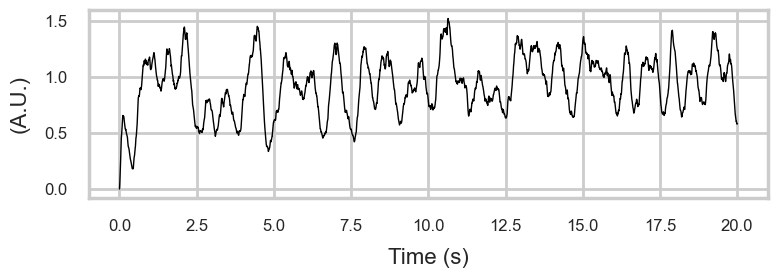

In [ ]:


# ─── Time-series trace ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(time_axis, ts, color='black', linewidth=1)

ax.set_xlabel('Time (s)', labelpad=10)
ax.set_ylabel('(A.U.)', labelpad=10)

plt.tight_layout()
plt.show()


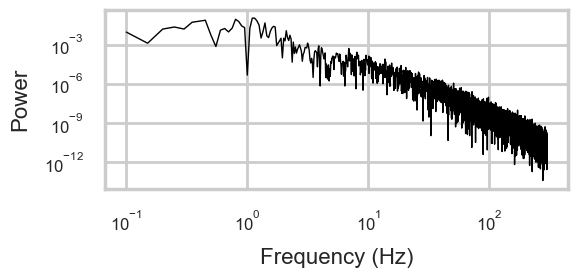

In [ ]:
from scipy.signal import periodogram
# Using your existing variables: ts (time series), FS (sampling rate)
freqs_hann, psd_hann = periodogram(ts, fs=FS, window='hann', scaling='density')

# Optionally restrict to FMIN–FMAX
mask_hann = (freqs_hann >= FMIN) & (freqs_hann <= FMAX)
fr_hann  = freqs_hann[mask_hann]
psd_hann = psd_hann[mask_hann]

# ─── Plot PSD ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 3))
ax.loglog(fr_hann, psd_hann, color='black', linewidth=1)

ax.set_xlabel('Frequency (Hz)', labelpad=10)
ax.set_ylabel('Power', labelpad=10)

plt.tight_layout()
plt.show()

In [ ]:
# ─── FULL-TRACE THEORETICAL SPECTRUM ──────────────────────────────
spec        = fpp.get_final_spectrum()
freqs_th    = fpp.model.frequencies
psd_th      = spec["final_total_spectrum"]
mask_th     = (freqs_th >= FMIN) & (freqs_th <= FMAX)
fr_th       = freqs_th[mask_th]
psd_th_full = psd_th[mask_th]

array([0., 0., 0., ..., 0., 0., 0.])

<Figure size 640x480 with 0 Axes>

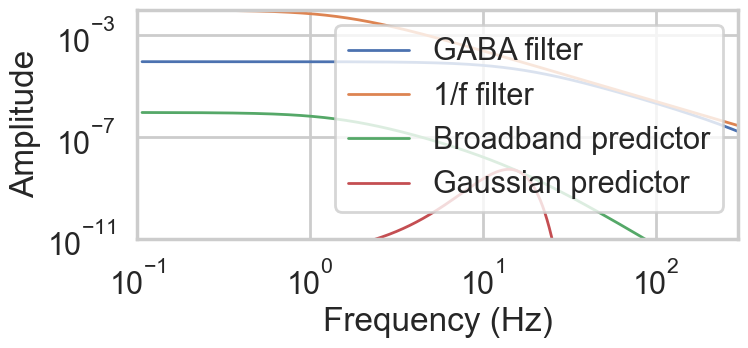

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import statsmodels.api as sm

# ─── Styling ─────────────────────────────────────────────────────────
sns.set_theme(style='whitegrid', context='poster')
sns.despine(trim=True)

# ─── 1) Extract & mask filter spectra ───────────────────────────────
freqs_full = fpp.model.frequencies
H_GABA     = fpp.filter_instances['f1'].kernel_spectrum   # GABA filter
H_1f       = fpp.filter_instances['f2'].kernel_spectrum   # 1/f filter

mask       = (freqs_full >= FMIN) & (freqs_full <= FMAX)
freqs      = freqs_full[mask]
gaba       = H_GABA[mask]
one_f      = H_1f[mask]

FS     = 1000.0
FMIN, FMAX     = 0.1, 300.0
CENTER_FREQ    = 16.0
PEAK_WIDTH     = 3.0

# ─── 2) Build predictors ────────────────────────────────────────────
bb    = gaba * one_f
gauss = bb * np.exp(-0.5 * ((freqs - CENTER_FREQ) / PEAK_WIDTH)**2)

# ─── 3) Plot filters & predictors ──────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
ax.loglog(freqs, gaba,   label='GABA filter',       lw=2)
ax.loglog(freqs, one_f,  label='1/f filter',        lw=2)
ax.loglog(freqs, bb,     label='Broadband predictor',lw=2)
ax.loglog(freqs, gauss,  label='Gaussian predictor', lw=2)

ax.set(xlabel='Frequency (Hz)',
       ylabel='Amplitude',
       xlim=(FMIN, FMAX))
ax.legend(loc='upper right', frameon=True)
ax.set_ylim(1e-11, 1e-2)
plt.tight_layout()
plt.show()



In [ ]:
from scipy.signal import periodogram

# ─── 1) Compute periodogram into fresh names ───────────────────────
freqs_raw, psd_raw = periodogram(
    ts, fs=FS, window='hann', scaling='density'
)

# ─── 2) Build your mask on the SAME two arrays ────────────────────
mask = (freqs_raw >= FMIN) & (freqs_raw <= FMAX)

# ─── 3) Index them in lock-step ───────────────────────────────────
fr_emp = freqs_raw[mask]
psd_emp = psd_raw[mask]

# ─── 4) Interpolate your full-spectrum filters onto fr_emp ────────
freqs_full = fpp.model.frequencies
Htot_full  = fpp.filter_instances['f1'].kernel_spectrum \
            * fpp.filter_instances['f2'].kernel_spectrum

bb_emp    = np.interp(fr_emp, freqs_full, Htot_full)
gauss_emp = bb_emp * np.exp(-0.5 * ((fr_emp - CENTER_FREQ)/PEAK_WIDTH)**2)

# ─── 5) Fit the GLM safely ────────────────────────────────────────
X = np.column_stack([bb_emp, gauss_emp])
gam = sm.GLM(psd_emp,
             X,
             family=sm.families.Gamma(link=sm.families.links.identity()))
res = gam.fit()

λ0_hat, bump_hat = res.params
print(f"Estimated λ₀ = {λ0_hat:.1f}, bump amplitude = {bump_hat:.1f}")



Estimated λ₀ = 1870.8, bump amplitude = 100.4


/Users/patrick_bloniasz/miniforge3/envs/filtered-point-process/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
